In [1]:
# Initial imports
import os
import csv
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import datetime as dt

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

In [2]:
# List the ticker symbols for the stocks of interest
lst_Stocks = ['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]
ticker = ['CL']

# Determine the Date range for the desired data
start_date = '2014-01-01'
end_date = '2022-12-31'
df = yf.download(ticker, start= start_date, end= end_date)
df = df.sort_index()


[*********************100%***********************]  1 of 1 completed


In [3]:
# Feature Engineering

# Mid Rang Variables
df['Mid_hl'] = (df['High'] + df['Low']) /2 
df['Mid_oc'] = (df['Open'] + df['Close']) /2 
df['Mid_hloc'] = (df['High'] + df['Low'] + df['Open'] + df['Close']) /4 

# Close in Range ==> Close at Low = 0, Close at High = 1
df['Close_in_range'] = 1 - ((df['High'] - df['Close']) / (df['High'] - df['Low']) )

# Daily/Weekly Returns - Average of Open and Close
df['Returns_1Day_Moc'] = df['Mid_oc'].pct_change()
df['Returns_5Day_Moc'] = df['Mid_oc'].pct_change(5)
df['Returns_30Day_Moc'] = df['Mid_oc'].pct_change(30)

# Daily/Weekly Returns - Average of High Low Open Close
df['Returns_1Day_Mhloc'] = df['Mid_hloc'].pct_change()
df['Returns_5Day_Mhloc'] = df['Mid_hloc'].pct_change(5)
df['Returns_30Day_Mhloc'] = df['Mid_hloc'].pct_change(30)

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Moc'] = df['Mid_oc'].rolling(10).std()
df['Std_Dev_30Day_Moc'] = df['Mid_oc'].rolling(30).std()

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Mhloc'] = df['Mid_hloc'].rolling(10).std()
df['Std_Dev_30Day_Mhloc'] = df['Mid_hloc'].rolling(30).std()

# Simple Moving Average - 8 Day vs 20 Day
df['SMA_Returns_8Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(8).std()
df['SMA_Returns_20Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(20).std()
df['SMA_Delta_8_20Day_Mhloc'] = df['SMA_Returns_8Day_Mhloc'] - df['SMA_Returns_20Day_Mhloc']
df['SMA_Signal_8_20Day_Mhloc'] = np.where(df['SMA_Returns_8Day_Mhloc'] < 1, 0, 1) 

# Display
display(df.columns)
display(df.head(10))
display(df.tail(10))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mid_hl',
       'Mid_oc', 'Mid_hloc', 'Close_in_range', 'Returns_1Day_Moc',
       'Returns_5Day_Moc', 'Returns_30Day_Moc', 'Returns_1Day_Mhloc',
       'Returns_5Day_Mhloc', 'Returns_30Day_Mhloc', 'Std_Dev_10Day_Moc',
       'Std_Dev_30Day_Moc', 'Std_Dev_10Day_Mhloc', 'Std_Dev_30Day_Mhloc',
       'SMA_Returns_8Day_Mhloc', 'SMA_Returns_20Day_Mhloc',
       'SMA_Delta_8_20Day_Mhloc', 'SMA_Signal_8_20Day_Mhloc'],
      dtype='object')

Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  64.889999  65.029999  64.000000  64.300003   
2014-01-03 00:00:00-05:00  64.209999  64.489998  63.990002  64.180000   
2014-01-06 00:00:00-05:00  64.440002  64.550003  63.990002  64.139999   
2014-01-07 00:00:00-05:00  64.489998  64.580002  64.029999  64.199997   
2014-01-08 00:00:00-05:00  64.169998  64.199997  63.410000  63.540001   
2014-01-09 00:00:00-05:00  64.129997  65.279999  63.799999  65.019997   
2014-01-10 00:00:00-05:00  65.120003  65.459999  64.879997  65.080002   
2014-01-13 00:00:00-05:00  64.900002  65.389999  64.540001  64.690002   
2014-01-14 00:00:00-05:00  64.699997  64.989998  64.559998  64.849998   
2014-01-15 00:00:00-05:00  64.860001  64.970001  64.349998  64.779999   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  51.943378  3004300  64.514999  64.595001   
2014-01-03 00:00:00-05:00  51.846432  2113700  64.240000  64.195000   
2014-01-06 00:00:00-05:00  51.814137  2583500  64.270002  64.290001   
2014-01-07 00:00:00-05:00  51.862579  2872100  64.305000  64.344997   
2014-01-08 00:00:00-05:00  51.329430  3286300  63.804998  63.855000   
2014-01-09 00:00:00-05:00  52.525013  4826400  64.539999  64.574997   
2014-01-10 00:00:00-05:00  52.573483  2956500  65.169998  65.100002   
2014-01-13 00:00:00-05:00  52.258434  3140800  64.965000  64.795002   
2014-01-14 00:00:00-05:00  52.387688  2480000  64.774998  64.774998   
2014-01-15 00:00:00-05:00  52.331135  2287400  64.660000  64.820000   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2014-01-02 00:00:00-05:00  64.555000        0.291265  ...                 NaN   
2014-01-03 00:00:00-05:00  64.217500        0.380000  ...                 NaN   
2014-01-06 00:00:00-05:00  64.280002        0.267852  ...                 NaN   
2014-01-07 00:00:00-05:00  64.324999        0.309086  ...                 NaN   
2014-01-08 00:00:00-05:00  63.829999        0.164559  ...                 NaN   
2014-01-09 00:00:00-05:00  64.557498        0.824323  ...            0.000039   
2014-01-10 00:00:00-05:00  65.135000        0.344834  ...            0.014287   
2014-01-13 00:00:00-05:00  64.880001        0.176473  ...            0.009334   
2014-01-14 00:00:00-05:00  64.774998        0.674420  ...            0.006996   
2014-01-15 00:00:00-05:00  64.740000        0.693546  ...            0.014257   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2014-01-02 00:00:00-05:00                  NaN                NaN   
2014-01-03 00:00:00-05:00                  NaN                NaN   
2014-01-06 00:00:00-05:00                  NaN                NaN   
2014-01-07 00:00:00-05:00                  NaN                NaN   
2014-01-08 00:00:00-05:00                  NaN                NaN   
2014-01-09 00:00:00-05:00                  NaN                NaN   
2014-01-10 00:00:00-05:00                  NaN                NaN   
2014-01-13 00:00:00-05:00                  NaN                NaN   
2014-01-14 00:00:00-05:00                  NaN                NaN   
2014-01-15 00:00:00-05:00                  NaN           0.365905   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2014-01-02 00:00:00-05:00                NaN                  NaN   
2014-01-03 00:00:00-05:00                NaN                  NaN   
2014-01-06 00:00:00-05:00                NaN                  NaN   
2014-01-07 00:00:00-05:00                NaN                  NaN   
2014-01-08 00:00:00-05:00                NaN                  NaN   
2014-01-09 00:00:

Open       High        Low      Close  \
Date                                                                    
2022-12-16 00:00:00-05:00  77.470001  78.120003  77.250000  77.760002   
2022-12-19 00:00:00-05:00  77.599998  78.919998  77.419998  77.980003   
2022-12-20 00:00:00-05:00  77.900002  78.070000  77.129997  77.690002   
2022-12-21 00:00:00-05:00  78.019997  78.989998  78.000000  78.989998   
2022-12-22 00:00:00-05:00  78.989998  79.309998  78.220001  79.279999   
2022-12-23 00:00:00-05:00  79.209999  79.580002  78.940002  79.449997   
2022-12-27 00:00:00-05:00  79.559998  80.230003  79.260002  79.940002   
2022-12-28 00:00:00-05:00  80.169998  80.440002  78.809998  78.820000   
2022-12-29 00:00:00-05:00  79.290001  79.660004  78.959999  79.370003   
2022-12-30 00:00:00-05:00  79.330002  79.449997  78.209999  78.790001   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2022-12-16 00:00:00-05:00  77.274002  9426200  77.685001  77.615002   
2022-12-19 00:00:00-05:00  77.492630  3440300  78.169998  77.790001   
2022-12-20 00:00:00-05:00  77.204437  2831900  77.599998  77.795002   
2022-12-21 00:00:00-05:00  78.496307  3025200  78.494999  78.504997   
2022-12-22 00:00:00-05:00  78.784500  2548400  78.764999  79.134998   
2022-12-23 00:00:00-05:00  78.953430  1488500  79.260002  79.329998   
2022-12-27 00:00:00-05:00  79.440376  3078600  79.745003  79.750000   
2022-12-28 00:00:00-05:00  78.327370  1918700  79.625000  79.494999   
2022-12-29 00:00:00-05:00  78.873940  1954200  79.310001  79.330002   
2022-12-30 00:00:00-05:00  78.297562  2238600  78.829998  79.060001   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2022-12-16 00:00:00-05:00  77.650002        0.586208  ...           -0.003881   
2022-12-19 00:00:00-05:00  77.980000        0.373337  ...           -0.003228   
2022-12-20 00:00:00-05:00  77.697500        0.595749  ...           -0.014835   
2022-12-21 00:00:00-05:00  78.499998        1.000000  ...           -0.008494   
2022-12-22 00:00:00-05:00  78.949999        0.972478  ...            0.010657   
2022-12-23 00:00:00-05:00  79.295000        0.796867  ...            0.021185   
2022-12-27 00:00:00-05:00  79.747501        0.701030  ...            0.022666   
2022-12-28 00:00:00-05:00  79.559999        0.006136  ...            0.023971   
2022-12-29 00:00:00-05:00  79.320002        0.585716  ...            0.010446   
2022-12-30 00:00:00-05:00  78.945000        0.467744  ...           -0.000063   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2022-12-16 00:00:00-05:00             0.073144           0.675402   
2022-12-19 00:00:00-05:00             0.067561           0.637244   
2022-12-20 00:00:00-05:00             0.056713           0.578567   
2022-12-21 00:00:00-05:00             0.061600           0.537500   
2022-12-22 00:00:00-05:00             0.072217           0.586760   
2022-12-23 00:00:00-05:00             0.062046           0.638167   
2022-12-27 00:00:00-05:00             0.068786           0.747894   
2022-12-28 00:00:00-05:00             0.060340           0.790597   
2022-12-29 00:00:00-05:00             0.053037           0.805162   
2022-12-30 00:00:00-05:00             0.039023           0.791953   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2022-12-16 00:00:00-05:00           1.634828             0.657949   
2022-12-19 00:00:00-05:00           1.524473             0.619180   
2022-12-20 00:00:00-05:00           1.421373             0.562727   
2022-12-21 00:00:00-05:00           1.346269             0.517951   
2022-12-22 00:00:00-05:00           1.256562             0.536541   
2022-12-23 00:00:

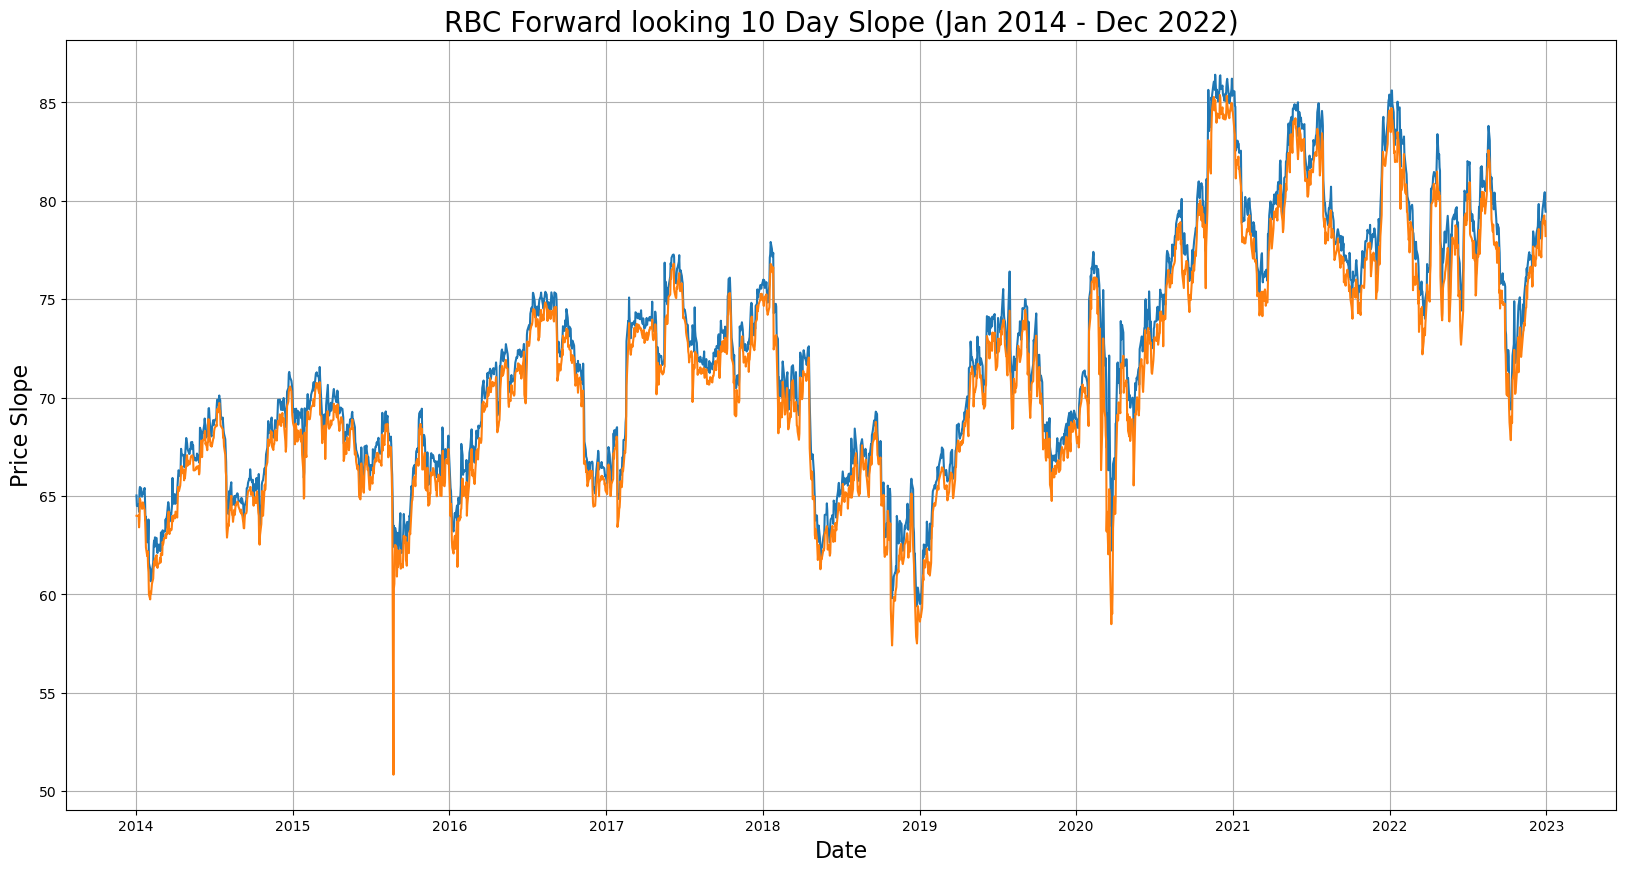

In [4]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['High']], label='High')
plt.plot(df[['Low']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


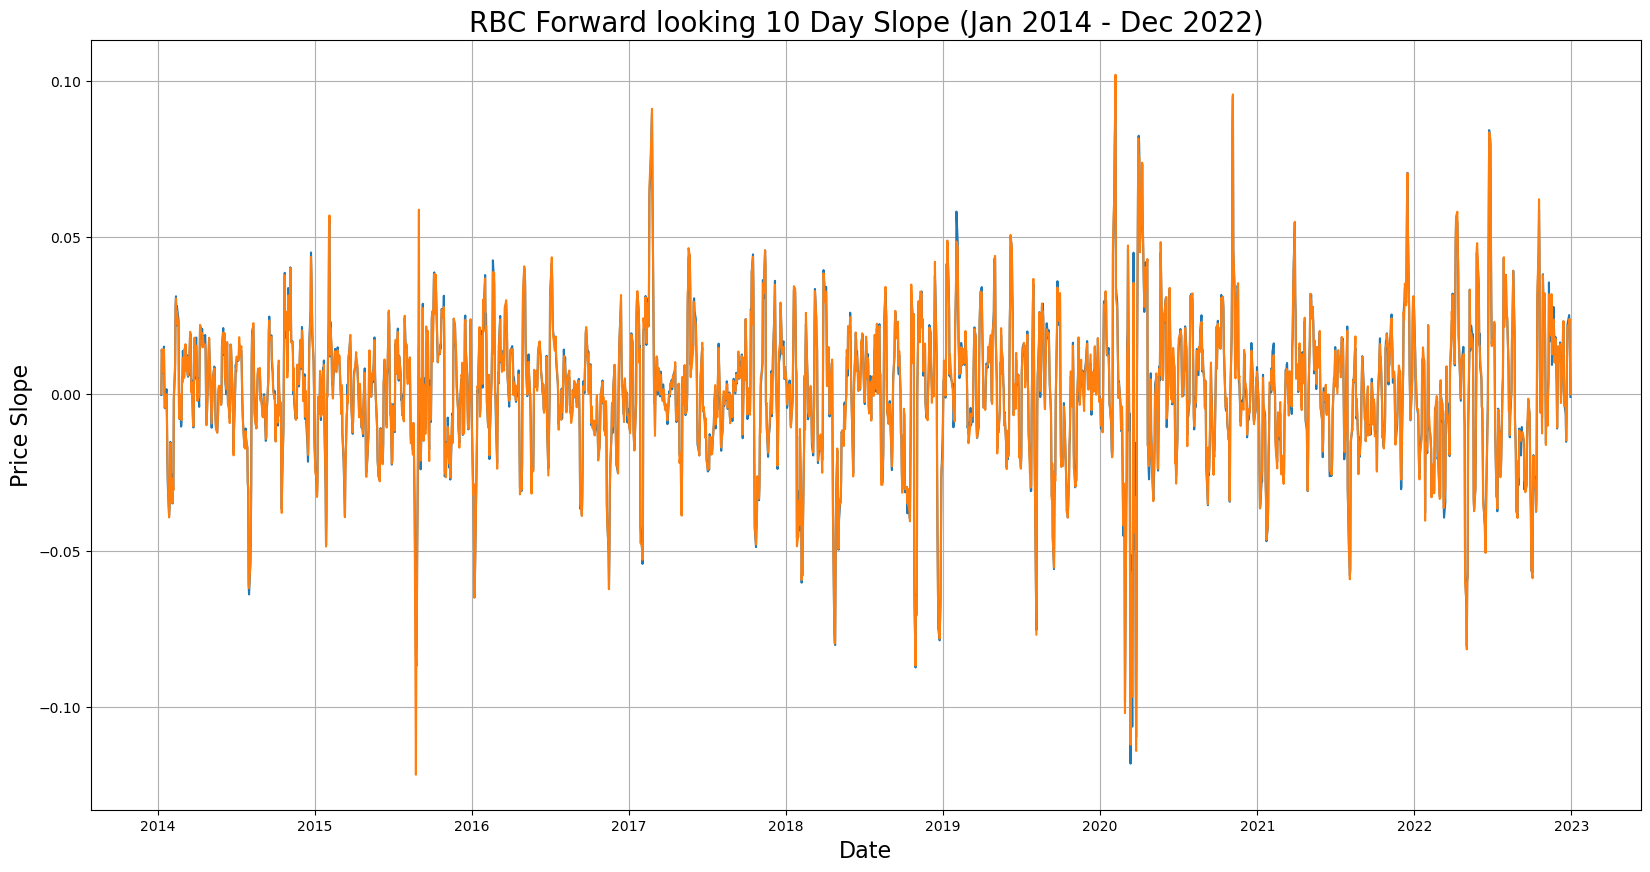

In [5]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Returns_5Day_Moc']], label='Open-Close')
plt.plot(df[['Returns_5Day_Mhloc']], label='High-Low-Open-Close')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


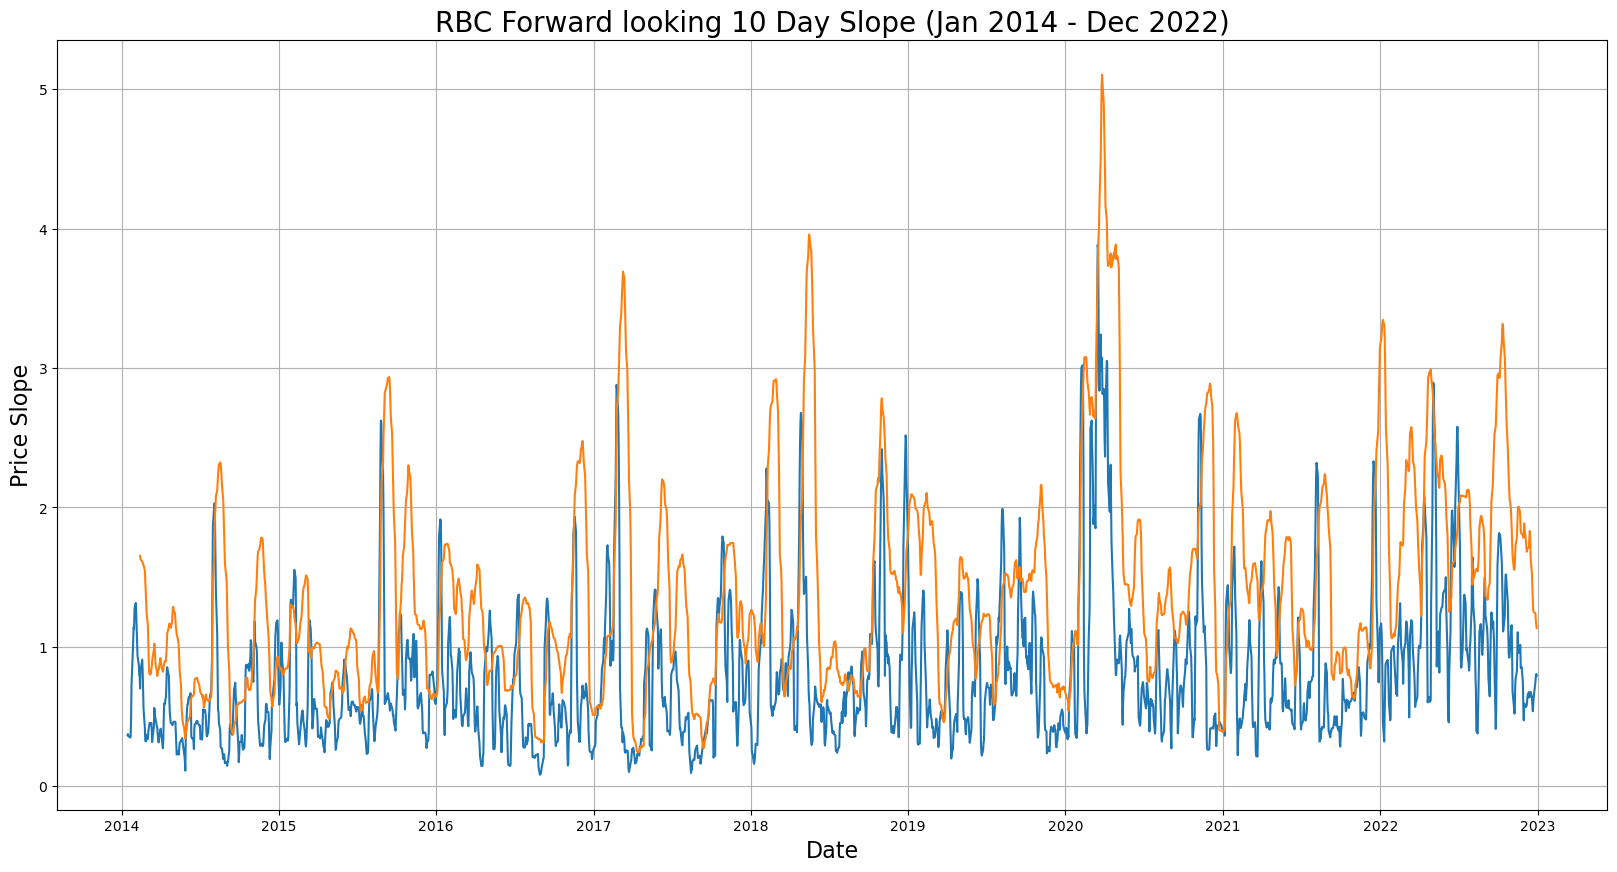

In [6]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Std_Dev_10Day_Moc']], label='High')
plt.plot(df[['Std_Dev_30Day_Moc']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [7]:
# Prepare df for trend determination
df = df.sort_index()
df = df.reset_index()
df

Date       Open       High        Low      Close  \
0    2014-01-02 00:00:00-05:00  64.889999  65.029999  64.000000  64.300003   
1    2014-01-03 00:00:00-05:00  64.209999  64.489998  63.990002  64.180000   
2    2014-01-06 00:00:00-05:00  64.440002  64.550003  63.990002  64.139999   
3    2014-01-07 00:00:00-05:00  64.489998  64.580002  64.029999  64.199997   
4    2014-01-08 00:00:00-05:00  64.169998  64.199997  63.410000  63.540001   
...                        ...        ...        ...        ...        ...   
2261 2022-12-23 00:00:00-05:00  79.209999  79.580002  78.940002  79.449997   
2262 2022-12-27 00:00:00-05:00  79.559998  80.230003  79.260002  79.940002   
2263 2022-12-28 00:00:00-05:00  80.169998  80.440002  78.809998  78.820000   
2264 2022-12-29 00:00:00-05:00  79.290001  79.660004  78.959999  79.370003   
2265 2022-12-30 00:00:00-05:00  79.330002  79.449997  78.209999  78.790001   

      Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0     51.943378  3004300  64.514999  64.595001  64.555000  ...   
1     51.846432  2113700  64.240000  64.195000  64.217500  ...   
2     51.814137  2583500  64.270002  64.290001  64.280002  ...   
3     51.862579  2872100  64.305000  64.344997  64.324999  ...   
4     51.329430  3286300  63.804998  63.855000  63.829999  ...   
...         ...      ...        ...        ...        ...  ...   
2261  78.953430  1488500  79.260002  79.329998  79.295000  ...   
2262  79.440376  3078600  79.745003  79.750000  79.747501  ...   
2263  78.327370  1918700  79.625000  79.494999  79.559999  ...   
2264  78.873940  1954200  79.310001  79.330002  79.320002  ...   
2265  78.297562  2238600  78.829998  79.060001  78.945000  ...   

      Returns_5Day_Mhloc  Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
0                    NaN                  NaN                NaN   
1                    NaN                  NaN                NaN   
2                    NaN                  NaN                NaN   
3                    NaN                  NaN                NaN   
4                    NaN                  NaN                NaN   
...                  ...                  ...                ...   
2261            0.021185             0.062046           0.638167   
2262            0.022666             0.068786           0.747894   
2263            0.023971             0.060340           0.790597   
2264            0.010446             0.053037           0.805162   
2265           -0.000063             0.039023           0.791953   

      Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  Std_Dev_30Day_Mhloc  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
...                 ...                  ...                  ...   
2261           1.250178             0.600713             1.219980   
2262           1.239356             0.720012             1.200291   
2263           1.190610             0.779669             1.176563   
2264           1.161145             0.791599             1.141329   
2265           1.133684             0.768990             1.116659   

      SMA_Returns_8Day_Mhloc  SMA_Returns_20Day_Mhloc  \
0                        NaN                      NaN   
1                        NaN                      NaN   
2                        NaN                      NaN   
3                        NaN                      NaN   
4                        NaN                      NaN   
...                      ...                      ...   
2261                0.007144                 0.006759   
2262                0.007336                 0.006540   
2263                0.005576                 0.006351   
2264                0.004491                 0.006199   
2265                0.0

In [8]:
# Calculate the 10-day forward looking slope of daily price benchmarks 
# Slope = coefecient from sklearn regression model
# Price Benchmarks = high, low, open, close

# Initialize X variable 1-10 
X = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])

# Initialize results dataframe
df_target_y = pd.DataFrame(columns = ['index', 'high_slope','high_intercept', 'mid_hl_slope', 'mid_hl_intercept', 'mid_oc_slope', 'mid_oc_intercept', 'low_slope', 'low_intercept', 'trend_10day'])

# Calculate from 1st to last less 10 days
for i in range(len(df) - 10):
    
    # Initialize y variables
    trend = 10
    y_High = np.array([])
    y_Mid_hl = np.array([])
    y_Mid_oc = np.array([])
    y_Low = np.array([])
    count = 0
    
    # Calculate y variables and add them to the array
    for j in range (i , i + 10):
        y_High = np.insert(y_High, len(y_High), df['High'].iloc[[j]])
        y_Mid_hl = np.insert(y_Mid_hl, len(y_Mid_hl), (df['High'].iloc[[j]] + df['Low'].iloc[[j]])/2)
        y_Mid_oc = np.insert(y_Mid_oc, len(y_Mid_oc), (df['Open'].iloc[[j]] + df['Close'].iloc[[j]])/2)
        y_Low = np.insert(y_Low, len(y_Low), df['Low'].iloc[[j]])
        count += 1
    
    # Reshape the y array for the regression model   
    y_High = y_High.reshape(-1,1)
    y_Mid_hl = y_Mid_hl.reshape(-1,1)
    y_Mid_oc = y_Mid_oc.reshape(-1,1)
    y_Low = y_Low.reshape(-1,1)
    
    # Regression models
    reg_High = LinearRegression().fit(X, y_High)
    reg_Mid_hl = LinearRegression().fit(X, y_Mid_hl)
    reg_Mid_oc = LinearRegression().fit(X, y_Mid_oc)
    reg_Low = LinearRegression().fit(X, y_Low)
    
    # Determine trend 
    # 0 - Down = 3 negative coefecients or 2 negative and the sum of all 4 is negative
    # 1 - Up   = 3 positive coefecients or 2 positive and the sum of all 4 is positive
    if (reg_High.coef_ > 0 and reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0): 
        trend = 1
    elif (reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ < 0 and reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0):
        trend = 0
    elif (reg_High.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0): 
        trend = 0
    elif (reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0):
        trend = 0
    elif (reg_High.coef_  + reg_Mid_hl.coef_ + reg_Mid_oc.coef_ + reg_Low.coef_ > 0):
        trend = 1    
    else: 
        trend =0
    
    # Populate result dataframe
    df_temp = pd.DataFrame({"index":i,  "high_slope": reg_High.coef_[0],     "high_intercept": reg_High.intercept_[0], 
                                        "mid_hl_slope": reg_Mid_hl.coef_[0], "mid_hl_intercept": reg_Mid_hl.intercept_[0],
                                        "mid_oc_slope": reg_Mid_oc.coef_[0], "mid_oc_intercept": reg_Mid_oc.intercept_[0], 
                                        "low_slope": reg_Low.coef_[0],       "low_intercept": reg_Low.intercept_[0],
                                        "trend_10day": trend})
    
    df_target_y = pd.concat([df_target_y,df_temp], axis = "rows")
    
    #print(f" row {i} xxx High: {reg_High.coef_} xxx Mid HiLo: {reg_Mid_hl.coef_} xxx Mid OpCl: {reg_Mid_oc.coef_} xxx Low: {reg_Low.coef_} xxx {trend}")
    #print('========================')

# Display result Dataframe
df_target_y = df_target_y.set_index(['index'])
display(df_target_y)

C:\Users\jersk\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


high_slope  high_intercept  mid_hl_slope  mid_hl_intercept  \
index                                                               
0        0.065939       64.531333      0.071848         64.129334   
1        0.087333       64.422666      0.083788         64.087667   
2        0.071091       64.574000      0.082121         64.162333   
3        0.067697       64.678665      0.072061         64.275665   
4        0.017152       64.968665      0.026485         64.524332   
...           ...             ...           ...               ...   
2251     0.000667       78.859333     -0.001273         78.295999   
2252     0.006243       78.950665      0.034424         78.222665   
2253     0.055819       78.829997      0.090667         78.071331   
2254     0.147758       78.423331      0.159212         77.783332   
2255     0.211152       78.056666      0.231121         77.398333   

       mid_oc_slope  mid_oc_intercept  low_slope  low_intercept trend_10day  
index                                                                        
0          0.070273         64.148000   0.077757      63.727335           1  
1          0.087697         64.070665   0.080242      63.752668           1  
2          0.077576         64.187332   0.093151      63.750667           1  
3          0.071303         64.282332   0.076424      63.872665           1  
4          0.027546         64.515999   0.035818      64.079999           1  
...             ...               ...        ...            ...         ...  
2251       0.012848         78.264334  -0.003212      77.732666           1  
2252       0.036454         78.280001   0.062606      77.494666           1  
2253       0.093666         78.110334   0.125516      77.312664           1  
2254       0.166060         77.761667   0.170667      77.143333           1  
2255       0.232788         77.413667   0.251091      76.740000           1  

[2256 rows x 9 columns]

In [9]:
df = pd.concat([df, df_target_y], axis= 1)
display(df.head(11))
display(df.tail(11))

Date       Open       High        Low      Close  \
0  2014-01-02 00:00:00-05:00  64.889999  65.029999  64.000000  64.300003   
1  2014-01-03 00:00:00-05:00  64.209999  64.489998  63.990002  64.180000   
2  2014-01-06 00:00:00-05:00  64.440002  64.550003  63.990002  64.139999   
3  2014-01-07 00:00:00-05:00  64.489998  64.580002  64.029999  64.199997   
4  2014-01-08 00:00:00-05:00  64.169998  64.199997  63.410000  63.540001   
5  2014-01-09 00:00:00-05:00  64.129997  65.279999  63.799999  65.019997   
6  2014-01-10 00:00:00-05:00  65.120003  65.459999  64.879997  65.080002   
7  2014-01-13 00:00:00-05:00  64.900002  65.389999  64.540001  64.690002   
8  2014-01-14 00:00:00-05:00  64.699997  64.989998  64.559998  64.849998   
9  2014-01-15 00:00:00-05:00  64.860001  64.970001  64.349998  64.779999   
10 2014-01-16 00:00:00-05:00  64.580002  65.120003  64.389999  64.980003   

    Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0   51.943378  3004300  64.514999  64.595001  64.555000  ...   
1   51.846432  2113700  64.240000  64.195000  64.217500  ...   
2   51.814137  2583500  64.270002  64.290001  64.280002  ...   
3   51.862579  2872100  64.305000  64.344997  64.324999  ...   
4   51.329430  3286300  63.804998  63.855000  63.829999  ...   
5   52.525013  4826400  64.539999  64.574997  64.557498  ...   
6   52.573483  2956500  65.169998  65.100002  65.135000  ...   
7   52.258434  3140800  64.965000  64.795002  64.880001  ...   
8   52.387688  2480000  64.774998  64.774998  64.774998  ...   
9   52.331135  2287400  64.660000  64.820000  64.740000  ...   
10  52.492706  2636400  64.755001  64.780003  64.767502  ...   

    SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
0                          1    0.065939       64.531333      0.071848   
1                          1    0.087333       64.422666      0.083788   
2                          1    0.071091       64.574000      0.082121   
3                          1    0.067697       64.678665      0.072061   
4                          1    0.017152       64.968665      0.026485   
5                          1   -0.112545       65.635999     -0.095818   
6                          1   -0.153212       65.726666     -0.182424   
7                          1   -0.236667       65.904666     -0.257879   
8                          0   -0.275454       65.872000     -0.297757   
9                          0   -0.318727       65.890002     -0.346030   
10                         0   -0.281030       65.566668     -0.350030   

    mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
0          64.129334      0.070273         64.148000   0.077757   
1          64.087667      0.087697         64.070665   0.080242   
2          64.162333      0.077576         64.187332   0.093151   
3          64.275665      0.071303         64.282332   0.076424   
4          64.524332      0.027546         64.515999   0.035818   
5          65.164999     -0.093848         65.141666  -0.079091   
6          65.504332     -0.191879         65.512335  -0.211636   
7          65.632333     -0.267212         65.645667  -0.279091   
8          65.611666     -0.315454         65.685000  -0.320060   
9          65.610667     -0.356455         65.652001  -0.373333   
10         65.413667     -0.348121         65.370668  -0.419030   

    low_intercept  trend_10day  
0       63.727335            1  
1       63.752668            1  
2       63.750667            1  
3       63.872665            1  
4       64.079999            1  
5       64.693998            0  
6       65.281998            0  
7       65.359999            0  
8       65.351332            0  
9       65.331332            0  
10      65.260666            0  

[11 rows x 34 columns]

Date       Open       High        Low      Close  \
2255 2022-12-15 00:00:00-05:00  78.510002  78.860001  77.220001  77.879997   
2256 2022-12-16 00:00:00-05:00  77.470001  78.120003  77.250000  77.760002   
2257 2022-12-19 00:00:00-05:00  77.599998  78.919998  77.419998  77.980003   
2258 2022-12-20 00:00:00-05:00  77.900002  78.070000  77.129997  77.690002   
2259 2022-12-21 00:00:00-05:00  78.019997  78.989998  78.000000  78.989998   
2260 2022-12-22 00:00:00-05:00  78.989998  79.309998  78.220001  79.279999   
2261 2022-12-23 00:00:00-05:00  79.209999  79.580002  78.940002  79.449997   
2262 2022-12-27 00:00:00-05:00  79.559998  80.230003  79.260002  79.940002   
2263 2022-12-28 00:00:00-05:00  80.169998  80.440002  78.809998  78.820000   
2264 2022-12-29 00:00:00-05:00  79.290001  79.660004  78.959999  79.370003   
2265 2022-12-30 00:00:00-05:00  79.330002  79.449997  78.209999  78.790001   

      Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
2255  77.393242  4021200  78.040001  78.195000  78.117500  ...   
2256  77.274002  9426200  77.685001  77.615002  77.650002  ...   
2257  77.492630  3440300  78.169998  77.790001  77.980000  ...   
2258  77.204437  2831900  77.599998  77.795002  77.697500  ...   
2259  78.496307  3025200  78.494999  78.504997  78.499998  ...   
2260  78.784500  2548400  78.764999  79.134998  78.949999  ...   
2261  78.953430  1488500  79.260002  79.329998  79.295000  ...   
2262  79.440376  3078600  79.745003  79.750000  79.747501  ...   
2263  78.327370  1918700  79.625000  79.494999  79.559999  ...   
2264  78.873940  1954200  79.310001  79.330002  79.320002  ...   
2265  78.297562  2238600  78.829998  79.060001  78.945000  ...   

      SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
2255                         0    0.211152       78.056666      0.231121   
2256                         0         NaN             NaN           NaN   
2257                         0         NaN             NaN           NaN   
2258                         0         NaN             NaN           NaN   
2259                         0         NaN             NaN           NaN   
2260                         0         NaN             NaN           NaN   
2261                         0         NaN             NaN           NaN   
2262                         0         NaN             NaN           NaN   
2263                         0         NaN             NaN           NaN   
2264                         0         NaN             NaN           NaN   
2265                         0         NaN             NaN           NaN   

      mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
2255         77.398333      0.232788         77.413667   0.251091   
2256               NaN           NaN               NaN        NaN   
2257               NaN           NaN               NaN        NaN   
2258               NaN           NaN               NaN        NaN   
2259               NaN           NaN               NaN        NaN   
2260               NaN           NaN               NaN        NaN   
2261               NaN           NaN               NaN        NaN   
2262               NaN           NaN               NaN        NaN   
2263               NaN           NaN               NaN        NaN   
2264               NaN           NaN               NaN        NaN   
2265               NaN           NaN               NaN        NaN   

      low_intercept  trend_10day  
2255          76.74            1  
2256            NaN          NaN  
2257            NaN          NaN  
2258            NaN          NaN  
2259            NaN          NaN  
2260            NaN          NaN  
2261            NaN          NaN  
2262            NaN          NaN  
2263            NaN          NaN  
2264            NaN          NaN  
2265            NaN          NaN  

[11 rows x 34 columns]

In [10]:
df = df.set_index(['Date'])
display(df.head(11))
display(df.tail(11))


Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  64.889999  65.029999  64.000000  64.300003   
2014-01-03 00:00:00-05:00  64.209999  64.489998  63.990002  64.180000   
2014-01-06 00:00:00-05:00  64.440002  64.550003  63.990002  64.139999   
2014-01-07 00:00:00-05:00  64.489998  64.580002  64.029999  64.199997   
2014-01-08 00:00:00-05:00  64.169998  64.199997  63.410000  63.540001   
2014-01-09 00:00:00-05:00  64.129997  65.279999  63.799999  65.019997   
2014-01-10 00:00:00-05:00  65.120003  65.459999  64.879997  65.080002   
2014-01-13 00:00:00-05:00  64.900002  65.389999  64.540001  64.690002   
2014-01-14 00:00:00-05:00  64.699997  64.989998  64.559998  64.849998   
2014-01-15 00:00:00-05:00  64.860001  64.970001  64.349998  64.779999   
2014-01-16 00:00:00-05:00  64.580002  65.120003  64.389999  64.980003   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  51.943378  3004300  64.514999  64.595001   
2014-01-03 00:00:00-05:00  51.846432  2113700  64.240000  64.195000   
2014-01-06 00:00:00-05:00  51.814137  2583500  64.270002  64.290001   
2014-01-07 00:00:00-05:00  51.862579  2872100  64.305000  64.344997   
2014-01-08 00:00:00-05:00  51.329430  3286300  63.804998  63.855000   
2014-01-09 00:00:00-05:00  52.525013  4826400  64.539999  64.574997   
2014-01-10 00:00:00-05:00  52.573483  2956500  65.169998  65.100002   
2014-01-13 00:00:00-05:00  52.258434  3140800  64.965000  64.795002   
2014-01-14 00:00:00-05:00  52.387688  2480000  64.774998  64.774998   
2014-01-15 00:00:00-05:00  52.331135  2287400  64.660000  64.820000   
2014-01-16 00:00:00-05:00  52.492706  2636400  64.755001  64.780003   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2014-01-02 00:00:00-05:00  64.555000        0.291265  ...   
2014-01-03 00:00:00-05:00  64.217500        0.380000  ...   
2014-01-06 00:00:00-05:00  64.280002        0.267852  ...   
2014-01-07 00:00:00-05:00  64.324999        0.309086  ...   
2014-01-08 00:00:00-05:00  63.829999        0.164559  ...   
2014-01-09 00:00:00-05:00  64.557498        0.824323  ...   
2014-01-10 00:00:00-05:00  65.135000        0.344834  ...   
2014-01-13 00:00:00-05:00  64.880001        0.176473  ...   
2014-01-14 00:00:00-05:00  64.774998        0.674420  ...   
2014-01-15 00:00:00-05:00  64.740000        0.693546  ...   
2014-01-16 00:00:00-05:00  64.767502        0.808221  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2014-01-02 00:00:00-05:00                         1    0.065939   
2014-01-03 00:00:00-05:00                         1    0.087333   
2014-01-06 00:00:00-05:00                         1    0.071091   
2014-01-07 00:00:00-05:00                         1    0.067697   
2014-01-08 00:00:00-05:00                         1    0.017152   
2014-01-09 00:00:00-05:00                         1   -0.112545   
2014-01-10 00:00:00-05:00                         1   -0.153212   
2014-01-13 00:00:00-05:00                         1   -0.236667   
2014-01-14 00:00:00-05:00                         0   -0.275454   
2014-01-15 00:00:00-05:00                         0   -0.318727   
2014-01-16 00:00:00-05:00                         0   -0.281030   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2014-01-02 00:00:00-05:00       64.531333      0.071848         64.129334   
2014-01-03 00:00:00-05:00       64.422666      0.083788         64.087667   
2014-01-06 00:00:00-05:00       64.574000      0.082121         64.162333   
2014-01-07 00:00:00-05:00       64.678665      0.072061         64.275665   
2014-01-08 00:00:00-05:00     

Open       High        Low      Close  \
Date                                                                    
2022-12-15 00:00:00-05:00  78.510002  78.860001  77.220001  77.879997   
2022-12-16 00:00:00-05:00  77.470001  78.120003  77.250000  77.760002   
2022-12-19 00:00:00-05:00  77.599998  78.919998  77.419998  77.980003   
2022-12-20 00:00:00-05:00  77.900002  78.070000  77.129997  77.690002   
2022-12-21 00:00:00-05:00  78.019997  78.989998  78.000000  78.989998   
2022-12-22 00:00:00-05:00  78.989998  79.309998  78.220001  79.279999   
2022-12-23 00:00:00-05:00  79.209999  79.580002  78.940002  79.449997   
2022-12-27 00:00:00-05:00  79.559998  80.230003  79.260002  79.940002   
2022-12-28 00:00:00-05:00  80.169998  80.440002  78.809998  78.820000   
2022-12-29 00:00:00-05:00  79.290001  79.660004  78.959999  79.370003   
2022-12-30 00:00:00-05:00  79.330002  79.449997  78.209999  78.790001   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2022-12-15 00:00:00-05:00  77.393242  4021200  78.040001  78.195000   
2022-12-16 00:00:00-05:00  77.274002  9426200  77.685001  77.615002   
2022-12-19 00:00:00-05:00  77.492630  3440300  78.169998  77.790001   
2022-12-20 00:00:00-05:00  77.204437  2831900  77.599998  77.795002   
2022-12-21 00:00:00-05:00  78.496307  3025200  78.494999  78.504997   
2022-12-22 00:00:00-05:00  78.784500  2548400  78.764999  79.134998   
2022-12-23 00:00:00-05:00  78.953430  1488500  79.260002  79.329998   
2022-12-27 00:00:00-05:00  79.440376  3078600  79.745003  79.750000   
2022-12-28 00:00:00-05:00  78.327370  1918700  79.625000  79.494999   
2022-12-29 00:00:00-05:00  78.873940  1954200  79.310001  79.330002   
2022-12-30 00:00:00-05:00  78.297562  2238600  78.829998  79.060001   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2022-12-15 00:00:00-05:00  78.117500        0.402437  ...   
2022-12-16 00:00:00-05:00  77.650002        0.586208  ...   
2022-12-19 00:00:00-05:00  77.980000        0.373337  ...   
2022-12-20 00:00:00-05:00  77.697500        0.595749  ...   
2022-12-21 00:00:00-05:00  78.499998        1.000000  ...   
2022-12-22 00:00:00-05:00  78.949999        0.972478  ...   
2022-12-23 00:00:00-05:00  79.295000        0.796867  ...   
2022-12-27 00:00:00-05:00  79.747501        0.701030  ...   
2022-12-28 00:00:00-05:00  79.559999        0.006136  ...   
2022-12-29 00:00:00-05:00  79.320002        0.585716  ...   
2022-12-30 00:00:00-05:00  78.945000        0.467744  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2022-12-15 00:00:00-05:00                         0    0.211152   
2022-12-16 00:00:00-05:00                         0         NaN   
2022-12-19 00:00:00-05:00                         0         NaN   
2022-12-20 00:00:00-05:00                         0         NaN   
2022-12-21 00:00:00-05:00                         0         NaN   
2022-12-22 00:00:00-05:00                         0         NaN   
2022-12-23 00:00:00-05:00                         0         NaN   
2022-12-27 00:00:00-05:00                         0         NaN   
2022-12-28 00:00:00-05:00                         0         NaN   
2022-12-29 00:00:00-05:00                         0         NaN   
2022-12-30 00:00:00-05:00                         0         NaN   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2022-12-15 00:00:00-05:00       78.056666      0.231121         77.398333   
2022-12-16 00:00:00-05:00             NaN           NaN               NaN   
2022-12-19 00:00:00-05:00             NaN           NaN               NaN   
2022-12-20 00:00:00-05:00             NaN           NaN               NaN   
2022-12-21 00:00:00-05:00     

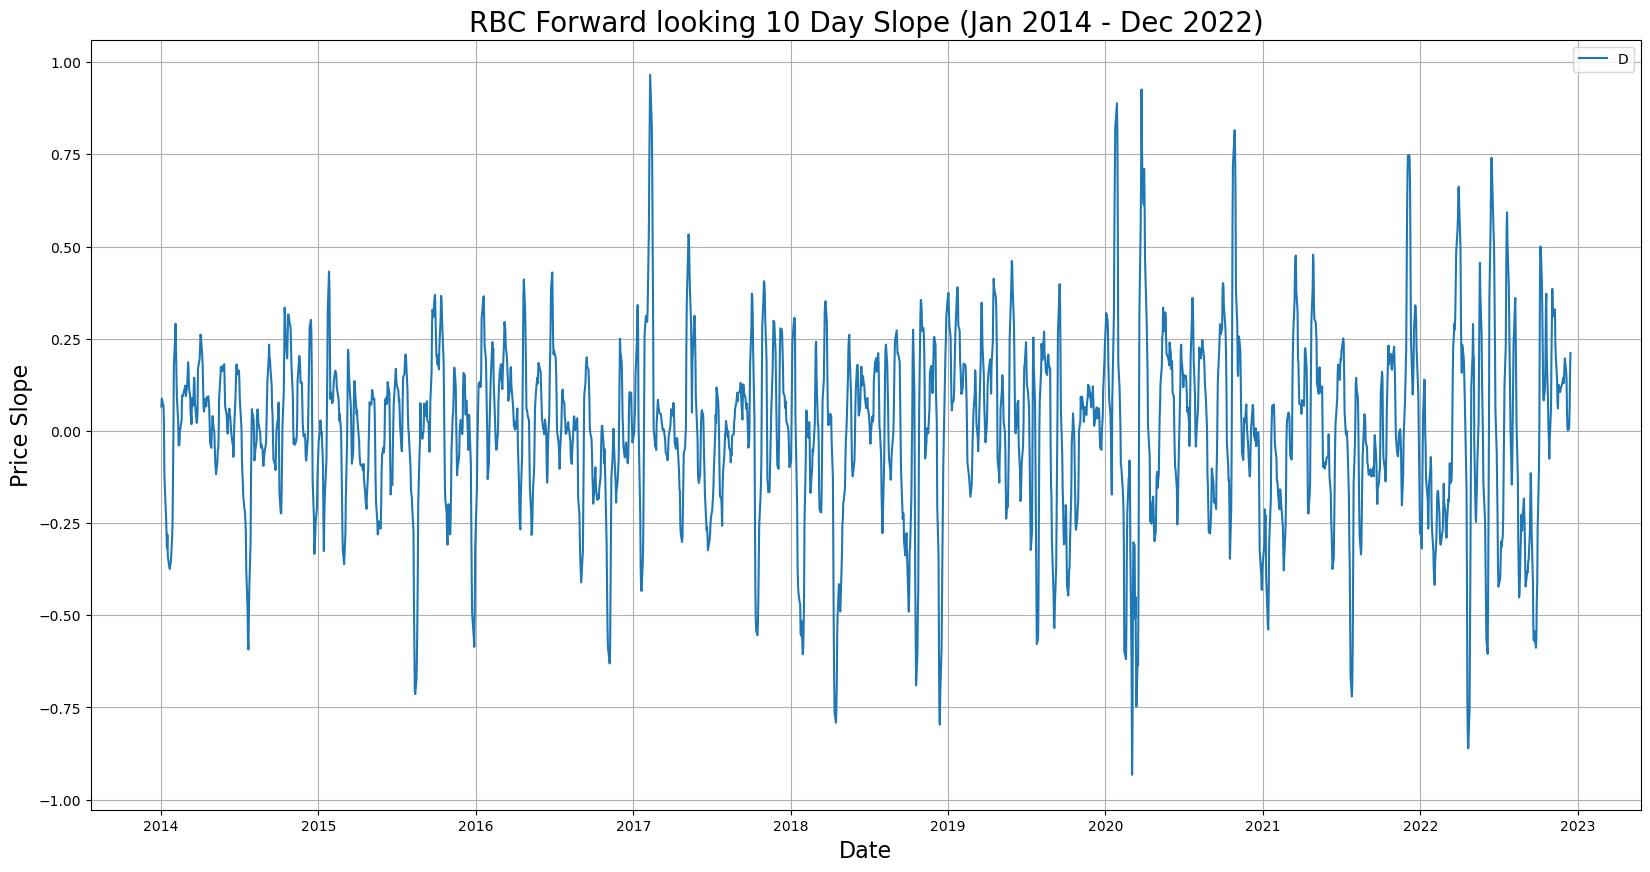

In [11]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['high_slope']])
#plt.title("Bank of Montreal (BMO) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend('Daily High')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [12]:
df.to_csv('../Data/Feature_Engineering_CL.csv', encoding='utf-8')

In [14]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mid_hl',
       'Mid_oc', 'Mid_hloc', 'Close_in_range', 'Returns_1Day_Moc',
       'Returns_5Day_Moc', 'Returns_30Day_Moc', 'Returns_1Day_Mhloc',
       'Returns_5Day_Mhloc', 'Returns_30Day_Mhloc', 'Std_Dev_10Day_Moc',
       'Std_Dev_30Day_Moc', 'Std_Dev_10Day_Mhloc', 'Std_Dev_30Day_Mhloc',
       'SMA_Returns_8Day_Mhloc', 'SMA_Returns_20Day_Mhloc',
       'SMA_Delta_8_20Day_Mhloc', 'SMA_Signal_8_20Day_Mhloc', 'high_slope',
       'high_intercept', 'mid_hl_slope', 'mid_hl_intercept', 'mid_oc_slope',
       'mid_oc_intercept', 'low_slope', 'low_intercept', 'trend_10day'],
      dtype='object')